In [2]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 38.3 MB/s eta 0:00:00m eta 0:00:01:01:01
  Using cached numpy-1.25.2-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 KB 29.2 MB/s eta 0:00:00
You should consider upgrading via the '/Users/lanacaldarevic/workspace/phd/water-plant-analysis/env/bin/python3 -m pip install --upgrade pip' command.


In [61]:
import pandas as pd
import numpy as np

```
Inputs to the device are: dotok, pretok, kisik.
dotok: t(d), Q(m3/d), T(C), COD(g/m3), NH4(g/m3), TN(g/m3), TSS(g/m3), TP(g /m3)
pretok: time(d),Qintr(m3/d),Qr(m3/d), Qw(m3/d), Quprimary(m3/d),Quthickener(m3/d),Qodewatering(m3/d ),Qmetal(m3/d)
kisik: t(d), DO5(g/m3), DO6(g/m3), DO6ref, DO7(g/m3)

Outputs from the device are: iztok, kvaliteta, stroski.
iztok: t(d), Q(m3/d), COD(g/m3), NH4(g/m3), TN(g/m3), TSS(g/m3), TP(g/m3) 
kvaliteta: t(d),EQI(kgPU/d)
stroski: t(d), SC, AE, PE, ME, OCI 

```

```
t is time, 
Q is flow, 
T is water temperature, 
COD organic matter (COD), 
NH4 ammonium nitrogen, 
TN total nitrogen, 
TSS insoluble matter (sludge), 
TP Total Phosphorus
```

In [62]:
df_inflow = pd.read_csv('data/dotok.txt', sep="   ", header=None, engine="python")
df_inflow.columns = ['t', 'Qi', 'T', 'CODi', 'NH4i', 'TNi', 'TSSi', 'TPi']

```
Qintr Internal Recycle Flow, 
Qr External Recycle Flow, 
Qw Excess Sludge Flow, 
QuPrimary Sludge Flow from Primary Settler, 
Quthickener Sludge Flow from Thickener, 
Qodewatering Sludge Flow from Dehydrator, 
```

In [63]:
df_flow = pd.read_csv('data/pretok.txt', sep="   ", header=None, engine="python")
df_flow.columns = ['t', 'Qintr', 'Qr', 'Qw', 'Quprimary', 'Quthickener', 'Qodewatering', 'Qmetal']
df_flow.set_index('t', inplace=True)

```
DO5 Oxygen in Pool 5, 
DO6 Oxygen in Pool 6
DO6ref oxygen set-point in pool 6, 
DO7 oxygen in pool 7, 

```

In [64]:
df_oxygen = pd.read_csv('data/kisik.txt', sep="   ", header=None, engine="python")
df_oxygen.columns = ['t', 'DO5', 'DO6', 'DO6ref', 'DO7']
df_oxygen.set_index('t', inplace=True)

In [65]:
df_outflow = pd.read_csv('data/iztok.txt', sep="   ", header=None, engine="python")
df_outflow.columns = ['t' ,'Qo', 'CODo', 'NH4o', 'TNo', 'TSSo', 'TPo']
df_outflow['t'] = df_inflow['t']
df_inflow.set_index('t', inplace=True)
df_outflow.set_index('t', inplace=True)

In [66]:
df_outflow

,Qo,CODo,NH4o,TNo,TSSo,TPo
t,,,,,,
0.000000,15310.074,40.747287,0.134206,8.547754,12.446315,1.151249
0.010417,14574.638,40.562989,0.134080,8.554336,12.214636,1.124317
0.020833,14065.519,40.397727,0.133868,8.561917,12.003069,1.099661
0.031250,13665.758,40.259636,0.133560,8.570511,11.819984,1.077628
0.041667,13314.130,40.148434,0.133149,8.579520,11.664954,1.058173
...,...,...,...,...,...,...
363.947920,14236.261,40.616090,0.148899,9.372274,11.866729,1.226980
363.958330,13464.764,40.430510,0.149850,9.360392,11.648107,1.203165
363.968750,12843.180,40.257301,0.150506,9.350149,11.443239,1.181034


```
EQI effluent quality
```

In [67]:
df_quality = pd.read_csv('data/kvaliteta.txt', sep="   ", header=None, engine="python")
df_quality.columns = ['t', 'EQI']
df_quality.set_index('t', inplace=True)

```
SC sludge costs, 
AE aeration costs, 
PE pump costs, 
ME methane production, 
OCI operating costs
```

In [68]:
df_cost = pd.read_csv('data/stroski.txt', sep="   ", header=None, engine="python")
df_cost.columns = ['t', 'SC', 'AE', 'PE', 'ME', 'OCI']
df_cost.set_index('t', inplace=True)

In [69]:
df = pd.concat([df_inflow, df_flow, df_oxygen, df_outflow, df_quality, df_cost], axis=1)

In [70]:
df = df.reset_index()

In [71]:
df['EQI_original'] = df.EQI * df.Qo / np.mean(df.Qo)

Sampling time is 0.01 d

Qintr, Qw, Qr, DO6ref vary randomly around preset values (+/- 10%).

We are interested in relations between inputs and outputs. Namely, we want to make a decision tree model for EQI(kgPU/d) and OCI primarily. It will be fine if you make a comparison between several models made with different algorithms - random forests, SVM, NN, etc. You can try it yourself first, and then we can meet on Zoom to see how you are doing and how to continue.

We are interested in feature engineering. This step consists of extracting a relevant feature subset to be used as input for models in further stages. You may use the ReliefF algorithm to select the variables that have the most influence on the results, which are compared using accuracy.


1.
- modelling for EQI and OCI

2.
- feature engineering

### Data preparation
Samling time is 0.01 d = 0.01 * 24h = 0.24 h * 60 min = 14.4 min. 


Every 14.4 minutes above variables were measured during 1 year. Average on hourly basis.

Treating plant as black box and only looking at dotok.txt and kvaliteta.txt with delay 0, 12 and 24 hours.

In [72]:
df_hourly = df.groupby(np.arange(len(df))//4).mean()
len(df_hourly)

8736

In [73]:
df_hourly.to_csv('data/df_hourly.csv', index=False)

### EDA

#### 1. No delay dataset

In [94]:
df_no_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8736 entries, 0 to 8735
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Q(m3/d)      8736 non-null   float64
 1   T(C)         8736 non-null   float64
 2   COD(g/m3)    8736 non-null   float64
 3   NH4(g/m3)    8736 non-null   float64
 4   TN(g/m3)     8736 non-null   float64
 5   TSS(g/m3)    8736 non-null   float64
 6   TP(g/m3)     8736 non-null   float64
 7   EQI(kgPU/d)  8736 non-null   float64
dtypes: float64(8)
memory usage: 872.3 KB


In [95]:
df_no_delay.describe()

,Q(m3/d),T(C),COD(g/m3),NH4(g/m3),TN(g/m3),TSS(g/m3),TP(g/m3),EQI(kgPU/d)
count,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000
mean,20935.404468,15.000011,660.541785,24.152434,50.385861,372.932378,9.746738,7307.962283
std,8447.445331,3.553348,225.681250,9.934189,16.916709,130.703440,3.341566,1016.927881
min,6500.850000,9.500000,58.150000,1.800000,6.360000,30.480000,1.200000,4032.500000
25%,14856.515000,11.480000,491.097500,16.710000,37.450000,270.520000,7.220000,6587.522500
50%,19819.645000,15.000000,676.840000,23.290000,51.180000,386.120000,9.790000,7179.375000
75%,25315.220000,18.520000,820.997500,30.542500,62.380000,462.885000,12.170000,7942.952500
max,76253.990000,20.500000,1333.020000,57.760000,101.070000,778.460000,20.910000,11624.330000


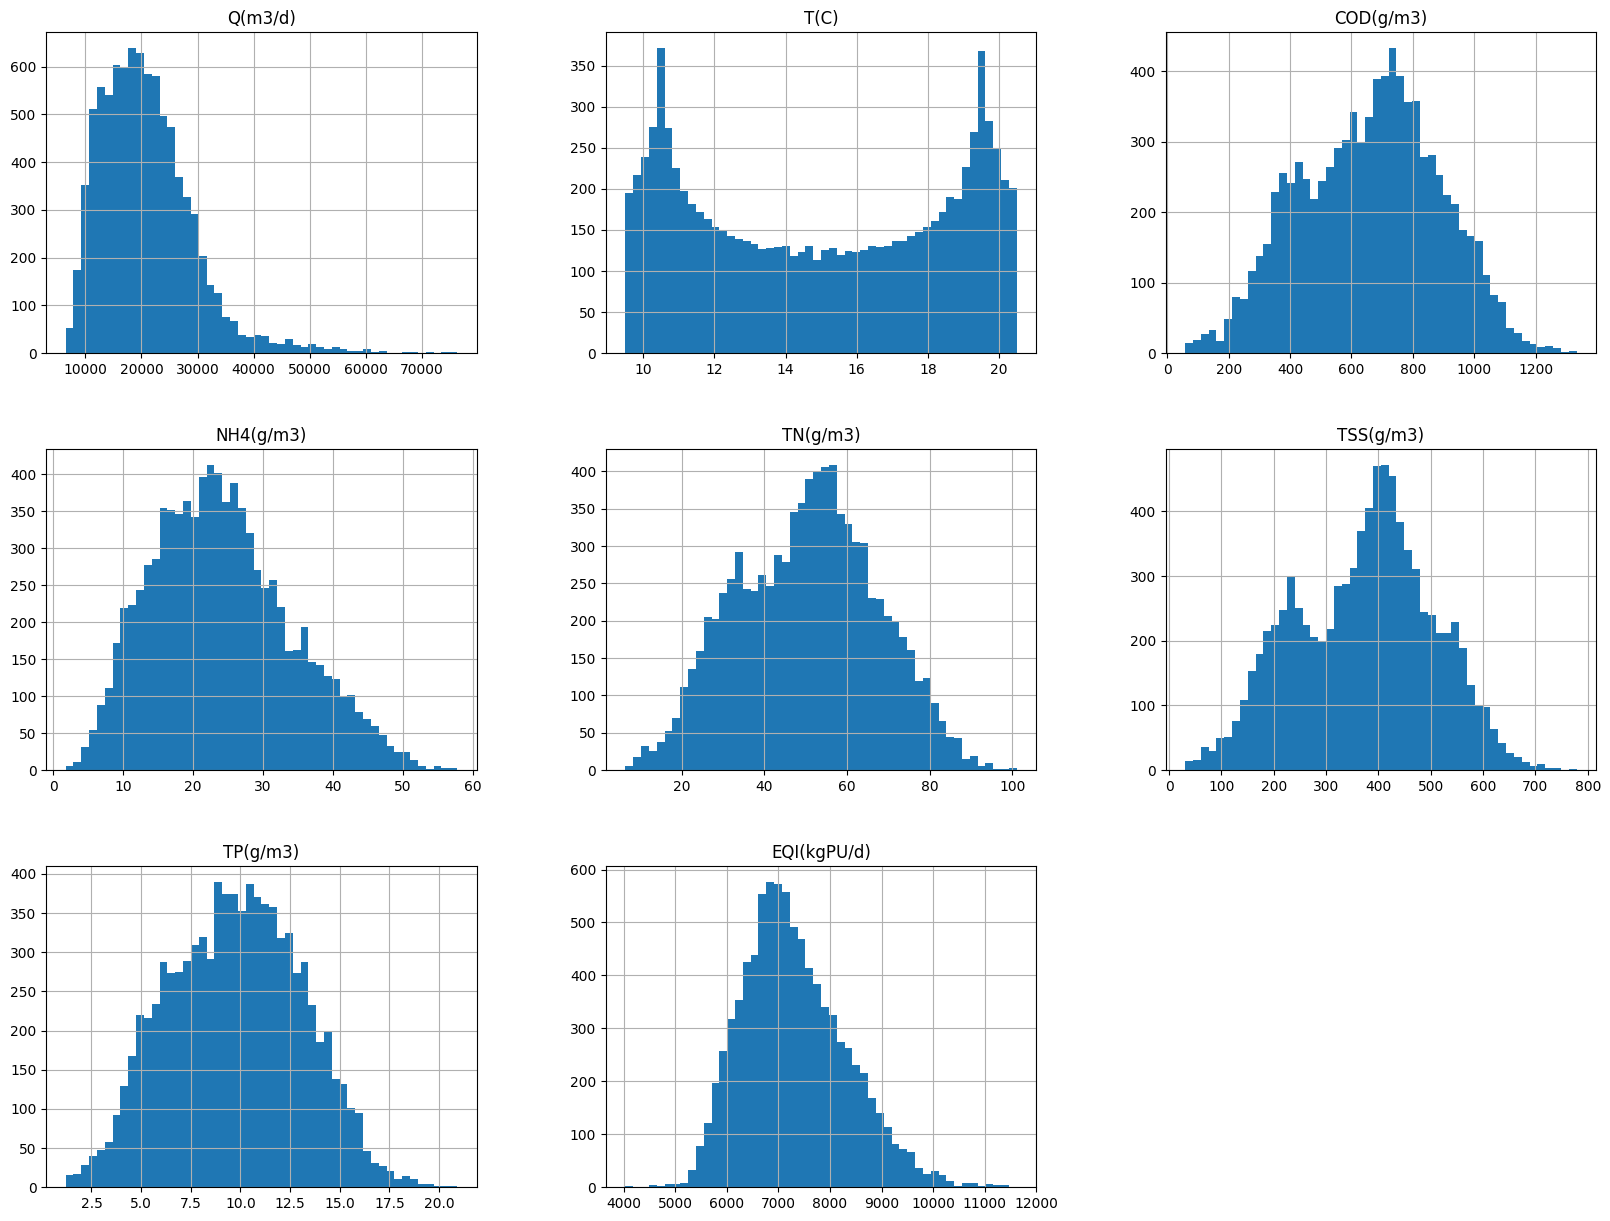

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
df_no_delay.hist(bins=50, figsize=(20,15))
plt.show()

### Modeling EQI - no delay

In [108]:
X = df_no_delay[['T(C)', 'COD(g/m3)', 'NH4(g/m3)', 'TN(g/m3)', 'TSS(g/m3)', 'TP(g/m3)']]
y = df_no_delay['EQI(kgPU/d)']

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [100]:
"""
from sklearn.model_selection import train_test_split

train_ratio = 0.9
validation_ratio = 0.05
test_ratio = 0.05


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
"""

'\nfrom sklearn.model_selection import train_test_split\n\ntrain_ratio = 0.9\nvalidation_ratio = 0.05\ntest_ratio = 0.05\n\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)\nX_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) \n'

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rnd_clf = RandomForestRegressor()
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mse**.5
print(mse)
print(rmse)
r2 = r2_score(y_test, y_pred_rf)
print(r2)

540395.3977918227
735.1159077260012
0.465904150700576


In [110]:
from sklearn.svm import SVR


svr = SVR()
svr.fit(X_train, y_train)
y_pred_svm = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_svm)
rmse = mse**.5
print(mse)
print(rmse)
r2 = r2_score(y_test, y_pred_svm)
print(r2)

981156.9242859001
990.533656311536
0.030139670527689066


### Modeling EQI - 12h delay

In [106]:
X = df_12h_delay[['T(C)', 'COD(g/m3)', 'NH4(g/m3)', 'TN(g/m3)', 'TSS(g/m3)', 'TP(g/m3)']]
y = df_12h_delay['EQI(kgPU/d)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
rnd_clf = RandomForestRegressor()
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mse**.5
print(mse)
print(rmse)
r2 = r2_score(y_test, y_pred_rf)
print(r2)

587755.2671193457
766.6519856619076
0.464937645826453


### Modeling EQI - 24h delay

In [107]:
X = df_24h_delay[['T(C)', 'COD(g/m3)', 'NH4(g/m3)', 'TN(g/m3)', 'TSS(g/m3)', 'TP(g/m3)']]
y = df_24h_delay['EQI(kgPU/d)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
rnd_clf = RandomForestRegressor()
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mse**.5
print(mse)
print(rmse)
r2 = r2_score(y_test, y_pred_rf)
print(r2)

394808.00106182386
628.337489779039
0.6091995945127415
